When diagonalizing the constraint, I have been performing an Eigendecomposition of $N_3^\top N_3$. But I know this matrix has at most $k$ (no. of time steps) non-zero Eigenvalues, so I can save time by finding the SVD of $N_3$ instead.

Using `svds`, an iterative method, and asking for $k$ singular values/vectors will give me a basis for the range of the matrix. To complete the basis, I can use the Gram-Schmidt process. In Julia, I can simply add linearly independent vectors (standard basis vectors work), perform a QR decomposition, and take Q. Unfortunately this is more expensive than just taking the SVD. Further testing required.

## Testing


In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton, JLD

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

In [8]:
i = testcase("timing")
@time o = solve_temporal_instanton(i);
sort(o.score)

r=0 check: 	removing 1 lines
  0.468054 seconds (28.30 k allocations: 3.450 MB)


104-element Array{Tuple{Float64,Int64},1}:
 (0.26378782300214965,25)
 (0.3273166237904137,30) 
 (1.2886117186013406,69) 
 (2.204151507636809,89)  
 (2.322973890826156,118) 
 (2.4231614563560475,64) 
 (4.678758549869784,42)  
 (4.865239912261385,102) 
 (4.899167705172113,31)  
 (5.678274911445937,80)  
 (5.938614560817055,1)   
 (6.43917233239348,100)  
 (6.460889255915008,62)  
 ⋮                       
 (178.08526259840306,99) 
 (303.0009254630288,103) 
 (370.6118283108055,66)  
 (370.6118283108058,67)  
 (391.30683149986237,33) 
 (428.9429217009969,40)  
 (923.990951705598,72)   
 (979.1908708682199,117) 
 (1319.8492895101356,79) 
 (1390.0600701887347,110)
 (1967.2796758073202,73) 
 (1967.2796758073239,74) 

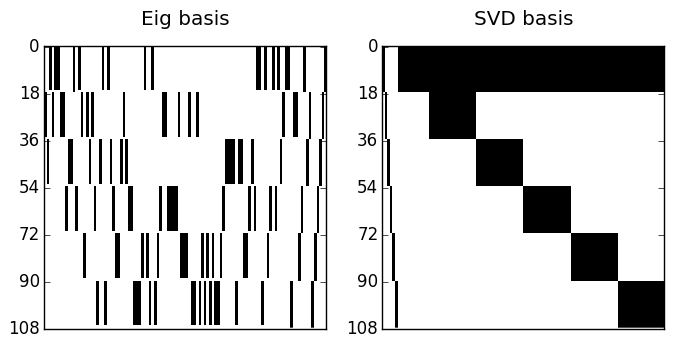

(Any[PyObject <matplotlib.axis.YTick object at 0x7f69e4d5ceb8>,PyObject <matplotlib.axis.YTick object at 0x7f69e4cfcf60>,PyObject <matplotlib.axis.YTick object at 0x7f69e4d21668>,PyObject <matplotlib.axis.YTick object at 0x7f69e4cc65c0>,PyObject <matplotlib.axis.YTick object at 0x7f69e75c06a0>,PyObject <matplotlib.axis.YTick object at 0x7f69e75cb400>,PyObject <matplotlib.axis.YTick object at 0x7f69e75c8fd0>],Any[PyObject <matplotlib.text.Text object at 0x7f69e4d21630>,PyObject <matplotlib.text.Text object at 0x7f69e4d56e80>,PyObject <matplotlib.text.Text object at 0x7f69e4cc6358>,PyObject <matplotlib.text.Text object at 0x7f69e75c0828>,PyObject <matplotlib.text.Text object at 0x7f69e76381d0>,PyObject <matplotlib.text.Text object at 0x7f69e75c83c8>,PyObject <matplotlib.text.Text object at 0x7f69e75c8940>])

In [9]:
using JLD
using PyPlot
PyPlot.svg(true)
rSVD = load("../data/rEig.jld")["rEig"]
rEig = load("../data/rEig2.jld")["rEig"]
rSVD = round(rSVD,15)
rEig = round(rEig,15)

subplot(121)
spy(rEig)
xticks([])
yticks(collect(linspace(0,108,7)))
title("Eig basis")
subplot(122)
spy(rSVD)
title("SVD basis")
xticks([])
yticks(collect(linspace(0,108,7)))
# yticks([])
# savefig("../images/eig_vs_svd_basis.png")

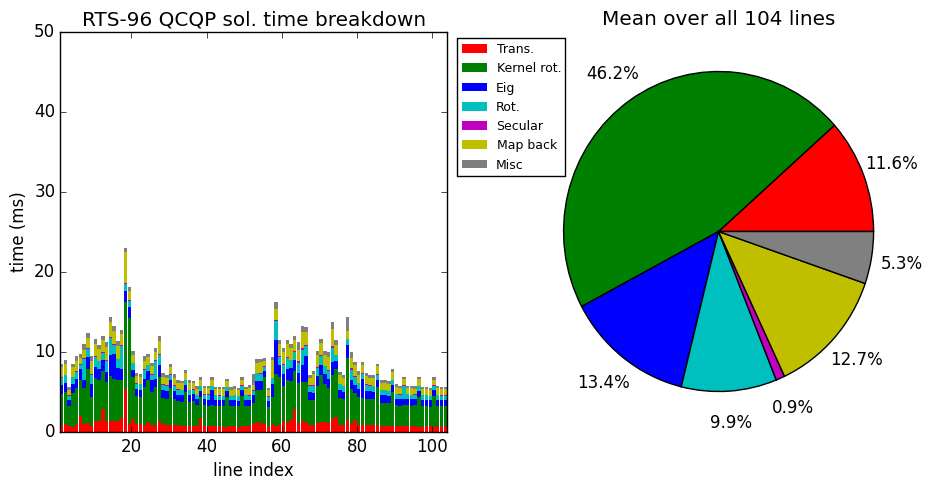

(Any[PyObject <matplotlib.patches.Wedge object at 0x7f35c4988e80>,PyObject <matplotlib.patches.Wedge object at 0x7f35c43611d0>,PyObject <matplotlib.patches.Wedge object at 0x7f35c43683c8>,PyObject <matplotlib.patches.Wedge object at 0x7f35c441c400>,PyObject <matplotlib.patches.Wedge object at 0x7f35c43705c0>,PyObject <matplotlib.patches.Wedge object at 0x7f35c43747b8>,PyObject <matplotlib.patches.Wedge object at 0x7f35c43799b0>],Any[PyObject <matplotlib.text.Text object at 0x7f35c43d9780>,PyObject <matplotlib.text.Text object at 0x7f35c4361978>,PyObject <matplotlib.text.Text object at 0x7f35c4414cf8>,PyObject <matplotlib.text.Text object at 0x7f35c4419748>,PyObject <matplotlib.text.Text object at 0x7f35c4370d68>,PyObject <matplotlib.text.Text object at 0x7f35c4374f60>,PyObject <matplotlib.text.Text object at 0x7f35c4382198>],Any[PyObject <matplotlib.text.Text object at 0x7f35c43d9c50>,PyObject <matplotlib.text.Text object at 0x7f35c4361e48>,PyObject <matplotlib.text.Text object at 0x7f

In [9]:
using PyPlot
PyPlot.svg(true)

t = load("../data/timing.jld")["timeVecs"]

tTrans    = [ti[1] for ti in t]*1e3
tKern     = [ti[2] for ti in t]*1e3
tEig      = [ti[3] for ti in t]*1e3
tRot      = [ti[4] for ti in t]*1e3
tSec      = [ti[5] for ti in t]*1e3
tMap      = [ti[6] for ti in t]*1e3
misc = o.linetimes*1e3 - (tMap+tSec+tRot+tEig+tKern+tTrans)

xvals = collect(1:length(tTrans))

fig = figure(figsize=(11,5))
subplot(1,2,1)
title("RTS-96 QCQP sol. time breakdown")
axis([1;length(xvals);0;50])
xlabel("line index")
ylabel("time (ms)")

bar(xvals, tTrans, color = "r", linewidth=0, width=0.9)
bar(xvals, tKern,  color = "g", bottom = tTrans, linewidth=0, width=0.9)
bar(xvals, tEig,   color = "b", bottom = tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tRot,   color = "c", bottom = tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tSec,   color = "m", bottom = tRot+tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tMap,   color = "y", bottom = tSec+tRot+tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, misc,   color = "k", bottom = tMap+tSec+tRot+tEig+tKern+tTrans, linewidth=0,width=0.9, alpha=0.5)

labels = ["Trans.";
    "Kernel rot.";
    "Eig";
    "Rot.";
    "Secular";
    "Map back";
    "Misc"]

legend(labels,loc=1,ncol=1,fontsize=9,
        bbox_to_anchor=(1.32, 1.0))

subplot(1,2,2)
title("Mean over all 104 lines")
sizes = [mean(tTrans);
    mean(tKern);
    mean(tEig);
    mean(tRot);
    mean(tSec);
    mean(tMap);
    mean(misc)]
scale!(sizes,1/sum(sizes))

colors = ["r";
    "g";
    "b";
    "c";
    "m";
    "y";
    "gray"]

pie(sizes, colors=colors, autopct="%1.1f%%", pctdistance=1.2)
# tight_layout()
# savefig("../images/2015-12-07-timing-analysis-reuse-temp.pdf")